In [1]:
import pandas as pd
#For testing
import pyfpgrowth
import pickle 

In [2]:

#Dummy dataframe for coding FP Growth
df = pd.DataFrame()
df['id'] = [100, 200, 300, 400, 500]
df['itemls'] = [['f', 'a', 'c', 'd', 'g', 'i', 'm', 'p'], ['a', 'b', 'c', 'f', 'l', 'm', 'o'],['b', 'f', 'h', 'j', 'o'], \
               ['b', 'c', 'k', 's', 'p'],['a', 'f', 'c', 'e', 'l', 'p', 'm', 'n']]
data = {100:['f', 'a', 'c', 'd', 'g', 'i', 'm', 'p'], 200:['a', 'b', 'c', 'f', 'l', 'm', 'o'], 300:['b', 'f', 'h', 'j', 'o'], \
        400:['b', 'c', 'k', 's', 'p'], 500:['a', 'f', 'c', 'e', 'l', 'p', 'm', 'n']}

In [12]:
with open('train_dict.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(len(data))
train_data = data
with open('test_dict.pickle', 'rb') as handle:
    test_data = pickle.load(handle)
print(f"{train_data = }")
print(f"{test_data = }")

607
train_data = {1: [1024, 1, 1025, 3, 2048, 1030, 1032, 2054, 2058, 527, 1042, 2580, 1049, 543, 3617, 1060, 2596, 552, 553, 47, 2096, 1073, 50, 1587, 2099, 3639, 1080, 2105, 1089, 1090, 2115, 1092, 2116, 70, 2628, 1097, 3147, 593, 2640, 596, 1620, 2641, 2644, 2648, 1625, 2137, 3671, 2141, 2654, 2143, 608, 2657, 3168, 101, 1644, 1136, 2161, 3702, 3703, 2174, 2692, 648, 1676, 2193, 3729, 661, 2716, 157, 3740, 3744, 673, 163, 3243, 1196, 1197, 1198, 3247, 3253, 1206, 1208, 1213, 1214, 1220, 1732, 1222, 1224, 2761, 1226, 3273, 3793, 216, 1240, 733, 223, 2273, 3809, 231, 1256, 1258, 235, 2797, 1265, 1777, 1275, 1278, 1282, 260, 2826, 1291, 780, 1804, 2329, 804, 296, 2858, 2353, 2872, 3386, 316, 2366, 1348, 333, 2387, 2899, 2395, 349, 2916, 2406, 362, 2414, 367, 3441, 1396, 3448, 3450, 2427, 1408, 1920, 2944, 2947, 2948, 2949, 1927, 2450, 2459, 3489, 1954, 1445, 2470, 423, 4006, 2985, 2987, 2478, 1967, 2997, 441, 954, 1473, 2502, 457, 2000, 2005, 3033, 3034, 2012, 480, 2528, 2018, 2529, 15

In [4]:
from collections import deque 

def traversetree(root):
    queue = deque([(root, root, 0)])
    while queue:
        parent_node, node, level = queue.popleft()
        print(f"{level = }")
        print(f"Parent: {parent_node.item}, Parent count: {parent_node.count}, Data: {node.item}, Count: {node.count}")
        for node_name in node.children:
            queue.append((node, node.children[node_name], level + 1))

def traverseheader(header_table):
    for key in header_table.keys():
        node = header_table[key]
        while node is not None:
            print(f"Header item: {key}, Link data: {node.item}, Link count: {node.count}")
            node = node.link 

In [21]:
#Global variable
id = 0
class Node:
    def __init__(self, item, count, parent):
        self.item = item           # Item value
        self.count = count         # Support count of the itemset
        self.parent = parent       # Parent node
        self.children = {}         # Children nodes (item: Node)
        self.link = None 

class FPGrowth:
    def __init__(self, data, minsup):
        self.data = data

    
    def find_frequent_items(self,data, minsup):
        header_table = {}
        for _, item_ls in data.items():
            for item in item_ls:
                header_table[item] = header_table.get(item, 0) + 1
        
        #Sort the dictionary
        # print(f"Before sorting {header_table = }")
        header_table = {k: v for k, v in sorted(header_table.items(), key=lambda item: (item[1], item[0]), reverse=True)}
        # print(f"After sorting {header_table = }")
        header_table = {k:-1 for k,v in header_table.items() if v>minsup}
        self.l = [*header_table.keys()]
        return header_table 
    
    #Constructing an FPTree
    def construct_fptree(self, data, header_table):
        root = Node(None,0,None)
        for _, transaction in data.items():
            ordered_transaction = [item for item in transaction if item in self.l]
            ordered_transaction.sort(key = lambda x:self.l.index(x))
            current_node = root
            # print(f"{ordered_transaction = }")
            for item in ordered_transaction:
                if item in current_node.children:
                    #Update the count of the already existing node
                    child_node = current_node.children[item]
                    child_node.count += 1
                else:
                    #Create a new node 
                    child_node = Node(item, 1, current_node)
                    current_node.children[item] = child_node
                    #Update header table
                    if item in header_table: #Why does this exist?
                        if header_table[item] == -1:
                            header_table[item] = child_node
                        else:
                            header_node = header_table[item]
                            while header_node.link is not None:
                                header_node =  header_node.link
                            header_node.link = child_node 
                current_node = child_node 
        return root, header_table

    #Mining an FPTree
    def mine_frequent_patterns(self, header_table, min_support, prefix=[]):
        global id
        frequent_patterns = []
        # Sort items in header table in descending order of frequency
        sorted_items = [item for item in header_table.keys()]
        sorted_items.sort(key=lambda x: (header_table[x].count, x))
        for item in sorted_items:
            new_prefix = prefix + [item]
            support = 0
            # Build the conditional pattern base
            conditional_dataset = {}
            node = header_table[item]
            while node is not None:
                count = node.count
                support += count 
                path = []
                current_node = node.parent
                while current_node.parent is not None:
                    path.append(current_node.item)
                    current_node = current_node.parent
                for _ in range(count):
                    conditional_dataset[id] = path
                    id += 1
                node = node.link
            frequent_patterns.append((new_prefix, support))
 
            
            # Recursively mine the conditional FP-tree
            conditional_header_table = self.find_frequent_items(conditional_dataset, min_support)
            root, conditional_header_table = self.construct_fptree(conditional_dataset, conditional_header_table)
            # print(f"Conditional prefix tree for prefix: {new_prefix}")
            # traversetree(root)
            # print()
            if conditional_header_table:
                frequent_patterns.extend(self.mine_frequent_patterns(conditional_header_table, min_support, new_prefix))
  
        return frequent_patterns
        

minsup = 50
FPGrowth_obj = FPGrowth(train_data, minsup)
header_table = FPGrowth_obj.find_frequent_items(train_data,minsup)
root, header_table = FPGrowth_obj.construct_fptree(train_data, header_table)
frequent_patterns = FPGrowth_obj.mine_frequent_patterns(header_table, minsup, [])
print(f"{frequent_patterns = }")
#For debugging
# traversetree(root)
# traverseheader(header_table)

frequent_patterns = [([1], 182), ([1, 593], 79), ([1, 593, 318], 53), ([1, 593, 356], 53), ([1, 593, 480], 54), ([1, 593, 296], 58), ([1, 2571], 70), ([1, 2571, 296], 53), ([1, 260], 90), ([1, 260, 356], 54), ([1, 260, 480], 54), ([1, 480], 93), ([1, 480, 296], 62), ([1, 480, 356], 61), ([1, 480, 318], 62), ([1, 318], 97), ([1, 318, 356], 59), ([1, 318, 296], 67), ([1, 356], 99), ([1, 356, 296], 67), ([1, 296], 101), ([2], 83), ([2, 356], 51), ([2, 480], 52), ([6], 80), ([10], 90), ([10, 589], 53), ([10, 588], 54), ([10, 480], 55), ([10, 356], 61), ([16], 64), ([21], 63), ([25], 53), ([32], 135), ([32, 47], 59), ([32, 110], 59), ([32, 150], 51), ([32, 457], 57), ([32, 480], 60), ([32, 527], 51), ([32, 589], 58), ([32, 592], 54), ([32, 1196], 55), ([32, 1210], 52), ([32, 2571], 55), ([32, 356], 62), ([32, 780], 63), ([32, 50], 64), ([32, 1], 67), ([32, 593], 66), ([32, 260], 67), ([32, 318], 72), ([32, 296], 75), ([34], 90), ([34, 318], 51), ([34, 480], 51), ([34, 296], 52), ([34, 1], 5

In [22]:
import itertools

def calc_confidence(data, antecedant, consequent):
    item_ls = [*data.values()]
    antecedant_union_consequent = set([antecedant] + list(consequent))
    support_antecedant = 0
    support_antecedant_union_consequent = 0
    for item in item_ls:
        if set([antecedant]).issubset(set(item)):
            support_antecedant += 1
        if set(antecedant_union_consequent).issubset(set(item)):
            support_antecedant_union_consequent += 1
    conf = support_antecedant_union_consequent / support_antecedant
    return conf  

def mine_association_rules(data, frequent_patterns, minconf):
    association_rules_ls = []
    for i_iter, frequent_pattern in enumerate(frequent_patterns):
        print(f"Processing  pattern {i_iter} out of {len(frequent_patterns)}")
        support = frequent_pattern[1]
        freq_itemset = frequent_pattern[0]
        if len(freq_itemset) > 1:
            for antecedant in freq_itemset:
                consequent_superset = [x for x in freq_itemset if x != antecedant]
                for i_iter in range(1, len(consequent_superset)+1):
                    consequent_ls = list(itertools.combinations(consequent_superset, i_iter))
                    for consequent in consequent_ls:
                        conf = calc_confidence(data, antecedant, consequent)
                        if conf > minconf:
                            association_rule = [antecedant] + list(consequent)
                            flag = True  
                            for x in association_rules_ls:
                                if association_rule == x[0]:
                                    flag = False 
                                    break 
                            if flag == True: 
                                association_rules_ls.append([association_rule, support, conf])
    return association_rules_ls 

minconf = 0.1
association_rules_ls = mine_association_rules(data, frequent_patterns, minconf)
print(f"{association_rules_ls = }")

Processing  pattern 0 out of 1763
Processing  pattern 1 out of 1763
Processing  pattern 2 out of 1763
Processing  pattern 3 out of 1763
Processing  pattern 4 out of 1763
Processing  pattern 5 out of 1763
Processing  pattern 6 out of 1763
Processing  pattern 7 out of 1763
Processing  pattern 8 out of 1763
Processing  pattern 9 out of 1763
Processing  pattern 10 out of 1763
Processing  pattern 11 out of 1763
Processing  pattern 12 out of 1763
Processing  pattern 13 out of 1763
Processing  pattern 14 out of 1763
Processing  pattern 15 out of 1763
Processing  pattern 16 out of 1763
Processing  pattern 17 out of 1763
Processing  pattern 18 out of 1763
Processing  pattern 19 out of 1763
Processing  pattern 20 out of 1763
Processing  pattern 21 out of 1763
Processing  pattern 22 out of 1763
Processing  pattern 23 out of 1763
Processing  pattern 24 out of 1763
Processing  pattern 25 out of 1763
Processing  pattern 26 out of 1763
Processing  pattern 27 out of 1763
Processing  pattern 28 out of 

In [47]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def compute_metrics(association_rules_ls, train_data, test_data, k):
    user_association_ls = []
    recall_ls = []
    precision_ls = []
    for user_id, transaction in train_data.items():
        for antecedant in transaction:
            for association_rule in association_rules_ls:
                if antecedant == association_rule[0][0]:
                    user_association_ls.append(association_rule)
        
        # print(f"{user_association_ls = }")
        #Sorting based on confidence
        user_association_ls = sorted(user_association_ls, key = lambda x: -x[2])
        user_recommendation_ls = [x[0][1:] for x in user_association_ls]
        user_recommendation_ls = flatten(user_recommendation_ls)[0:k]
        test_item_ls = test_data[user_id]
        hit_set = set(user_recommendation_ls).intersection(set(test_item_ls))
        recall = len(hit_set)/len(test_item_ls)
        precision = len(hit_set)/len(user_recommendation_ls)
        recall_ls.append(recall)
        precision_ls.append(precision)
        if int(user_id) % 300 == 0:
            print(f"{user_id = }, {k=}")
            print(f"Mean precision: {sum(precision_ls)/len(precision_ls)}")
            print(f"Mean Recall: {sum(recall_ls)/len(recall_ls)}")
    
    return sum(precision_ls)/len(precision_ls), sum(recall_ls)/len(recall_ls) 

mean_precision_ls = []
mean_recall_ls = []
k_ls = []
for k in range(5, 10):
    k_ls.append(k)
    mean_precision, mean_recall = compute_metrics(association_rules_ls, train_data, test_data, k)
    mean_precision_ls.append(mean_precision)
    mean_recall_ls.append(mean_recall)
    print(f"{mean_precision_ls =}")
    print(f"{mean_recall_ls = }")

user_id = 300, k=5
Mean precision: 0.02541806020066891
Mean Recall: 0.007333848465142667
user_id = 600, k=5
Mean precision: 0.023450586264656587
Mean Recall: 0.007037636686004624
mean_precision_ls =[0.02405271828665565]
mean_recall_ls = [0.007202939623076407]
user_id = 300, k=6
Mean precision: 0.021181716833890755
Mean Recall: 0.007333848465142667
user_id = 600, k=6
Mean precision: 0.019542155220547166
Mean Recall: 0.007037636686004624
mean_precision_ls =[0.02405271828665565, 0.02004393190554639]
mean_recall_ls = [0.007202939623076407, 0.007202939623076407]
user_id = 300, k=7
Mean precision: 0.020066889632107034
Mean Recall: 0.007878740456159425
user_id = 600, k=7
Mean precision: 0.017707585546781528
Mean Recall: 0.007310539039964441
mean_precision_ls =[0.02405271828665565, 0.02004393190554639, 0.018121911037891264]
mean_recall_ls = [0.007202939623076407, 0.007202939623076407, 0.007471346056872141]
user_id = 300, k=8
Mean precision: 0.017558528428093644
Mean Recall: 0.00787874045615942

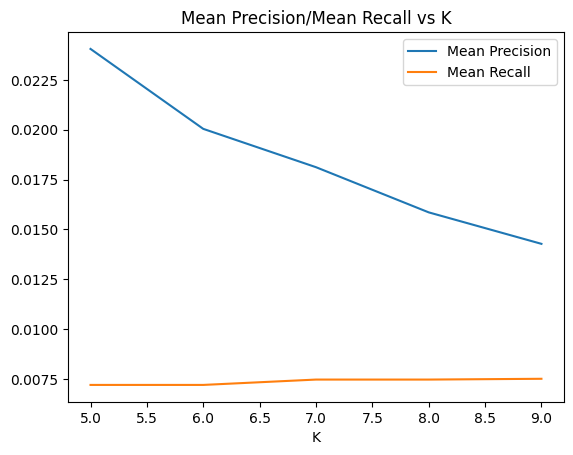

In [48]:
import matplotlib.pyplot as plt
plt.plot(k_ls, mean_precision_ls, label='Mean Precision')
plt.plot(k_ls, mean_recall_ls, label='Mean Recall')
plt.xlabel(f"K")
plt.legend()
plt.title(f"Mean Precision/Mean Recall vs K")
plt.show()

In [11]:
print(len(association_rules_ls))

5861


In [8]:
#Testing with in-built python package
transactions = [['f', 'a', 'c', 'd', 'g', 'i', 'm', 'p'], ['a', 'b', 'c', 'f', 'l', 'm', 'o'],['b', 'f', 'h', 'j', 'o'], \
               ['b', 'c', 'k', 's', 'p'],['a', 'f', 'c', 'e', 'l', 'p', 'm', 'n']]
patterns = pyfpgrowth.find_frequent_patterns(transactions, 3)
print(f"{patterns = }")

patterns = {('a', 'c'): 3, ('a', 'f'): 3, ('a', 'm'): 3, ('c', 'm'): 3, ('a', 'c', 'm'): 3, ('f', 'm'): 3, ('a', 'f', 'm'): 3, ('p',): 3, ('c', 'p'): 3, ('b',): 3, ('f',): 4, ('c',): 4}


In [9]:

frequent_patterns  = [(['b'], 3), (['a'], 3), (['a', 'c'], 3), (['a', 'c', 'f'], 3), (['a', 'c', 'f', 'm'], 3), (['a', 'c', 'm'], 3), (['a', 'f'], 3), (['a', 'f', 'm'], 3), (['a', 'm'], 3), (['m'], 3), (['m', 'c'], 3), (['m', 'c', 'f'], 3), (['m', 'f'], 3), (['p'], 3), (['p', 'c'], 3), (['c'], 4), (['c', 'f'], 3), (['f'], 4)]
patterns = {('a', 'c'): 3, ('a', 'f'): 3, ('a', 'm'): 3, ('c', 'm'): 3, ('a', 'c', 'm'): 3, ('f', 'm'): 3, ('a', 'f', 'm'): 3, ('p',): 3, ('c', 'p'): 3, ('b',): 3, ('f',): 4, ('c',): 4}